# <font color='green'><b> Image Stitching </b></font>


https://towardsdatascience.com/image-panorama-stitching-with-opencv-2402bde6b46c

In [2]:
#@title ▶️ Base dir setup
import os, sys

# check if hosted (Google VM) or running on local server
if 'google.colab' in sys.modules:
  #@markdown Google Drive root folder - hosted by Google VM (adapt to your local paths)
  from google.colab import drive
  drive.mount('/content/drive', force_remount=False)
  base_dir = 'infoMM/' #@param {type: "string"}
  base_dir  = os.path.join('/content/drive/MyDrive/', base_dir)
  #!pip install pillow  --upgrade
  img_dir = 'data/img/'
  vid_dir = 'data/video/'
  out_dir = 'output/'
  
  # move to base_dir 
  os.chdir(base_dir)
else:
  #@markdown Path to local folder on PC (adapt to your local paths)
  img_dir = '../Immagini_IN/'
  out_dir = '../Immagini_OUT/'

 

print("Current dir:", os.getcwd())

Current dir: c:\Users\eumir\Desktop\Università\Anno III\Semestre 1\Informazione Multimediale\IMMAGINI\Lab 8


In [3]:
!pip3 install imutils 


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\eumir\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import cv2 
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import ndimage
from scipy.spatial import distance
from scipy.spatial import distance_matrix
import pickle
import math
import matplotlib.pyplot as plt
import imutils
from skimage.io import imread
from skimage.color import rgb2gray
from skimage import img_as_float, img_as_ubyte
 

cv2.ocl.setUseOpenCL(False)

cv2.__version__

'4.8.1'

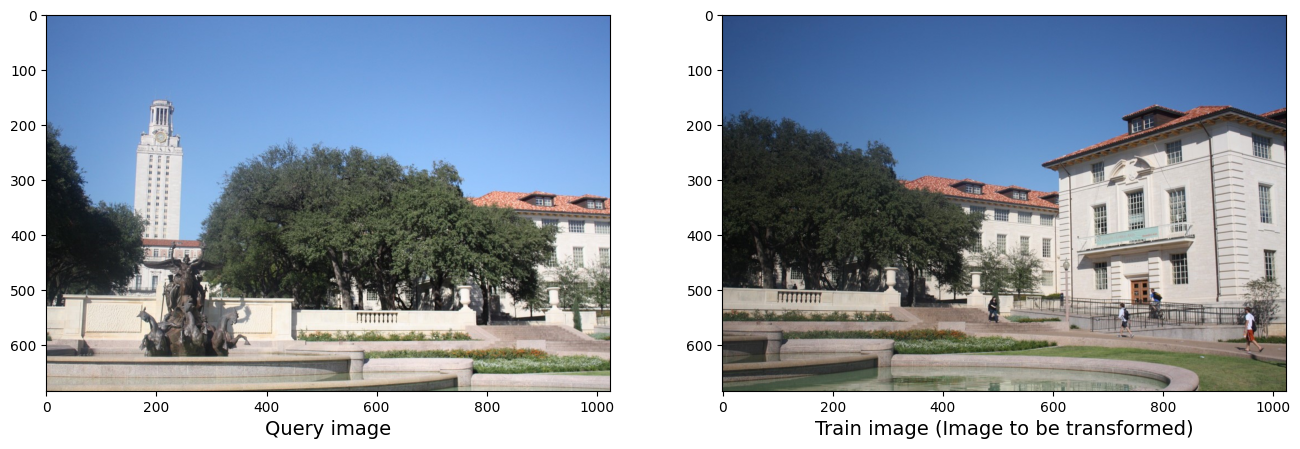

In [5]:
# read images and transform them to grayscale
# Make sure that the train image is the image that will be transformed
 
# load an example image 
trainImg = plt.imread(img_dir + 'foto1A.jpg') #  yosemite2
trainImg_gray = img_as_ubyte(rgb2gray(trainImg))

queryImg = plt.imread(img_dir +  'foto1B.jpg')#  yosemite1
queryImg_gray = img_as_ubyte(rgb2gray(queryImg))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

In [7]:
def detectAndDescribe(image ):
    """
    Compute key points and feature descriptors using the SIFT  method (alternatively: surf, brisk, orb)
    """
    descriptor = cv2.SIFT_create()    
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

kpsA, featuresA = detectAndDescribe(trainImg_gray )
kpsB, featuresB = detectAndDescribe(queryImg_gray )

### <font color='green'><b> EXERCISE: </b></font>
 
modify the function "detectAndDescribe" to allow the choice among SIFT, orb or brisk methods.
HINT: https://docs.opencv.org/4.x/

In [24]:
def detectAndDescribe(image, method=None):
#TO DO 

    #METODO DI DEFAULT = SIFT
    if method == None:
        descriptor = cv2.SIFT_create() 
        
    if method == "orb":
        descriptor = cv2.ORB_create()
    if method == "brisk":
        descriptor = cv2.BRISK_create()

    (kps, features) = descriptor.detectAndCompute(image, None)
    return (kps, features)

kpsA, featuresA = detectAndDescribe(trainImg_gray, "brisk")
kpsB, featuresB = detectAndDescribe(queryImg_gray, "brisk")

Text(0.5, 0, '(b)')

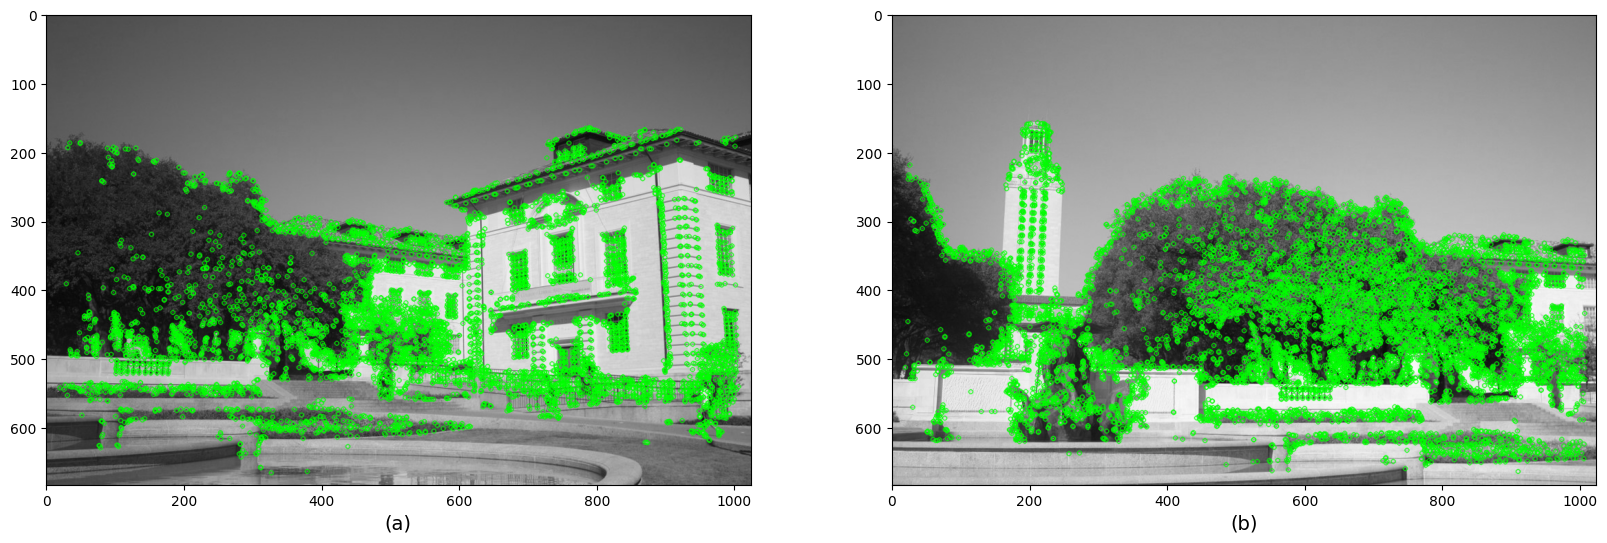

In [25]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

In [18]:
def matchKeyPointsBF(featuresA, featuresB):

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)    
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

Raw matches (Brute force): 197


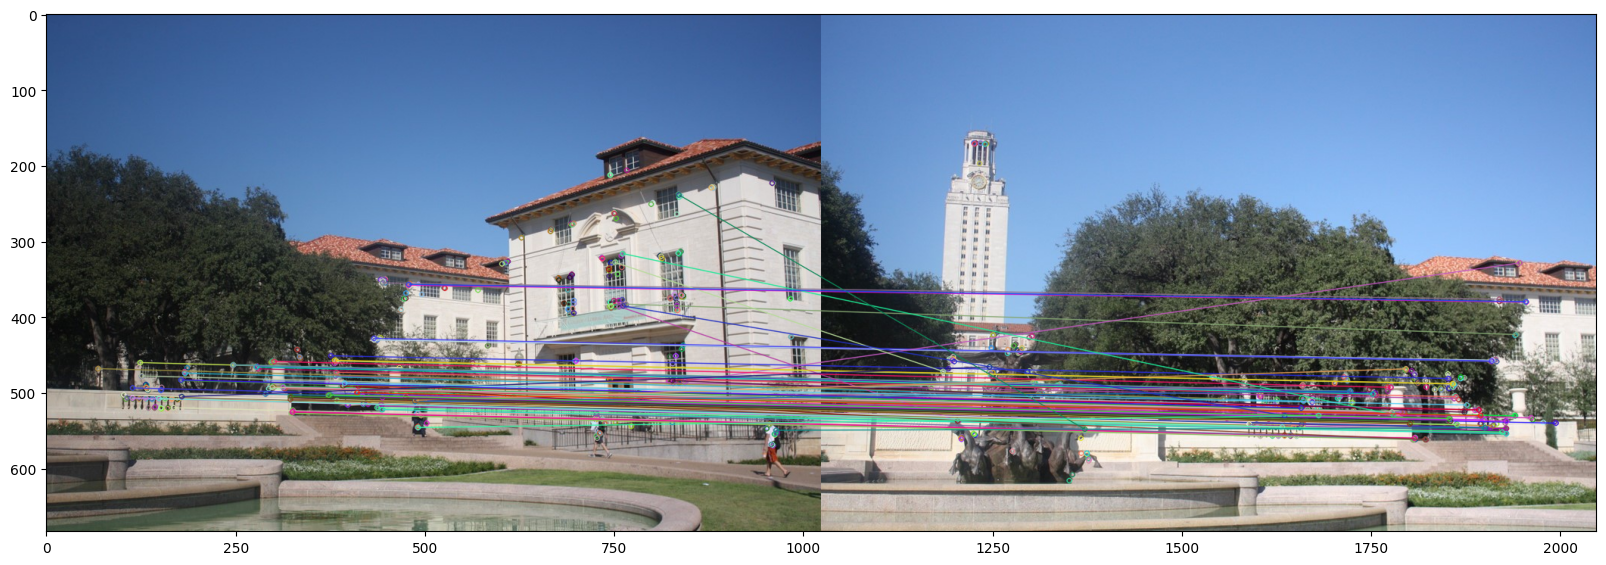

In [19]:
fig = plt.figure(figsize=(20,8))
 
matches = matchKeyPointsBF(featuresA, featuresB)
img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100], None)
 

plt.imshow(img3)
plt.show()

In [20]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [21]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 7.27048267e-01 -6.83442309e-02  4.60040456e+02]
 [-1.12647805e-01  7.65007761e-01  1.06698199e+02]
 [-1.72096910e-04 -1.90850124e-04  1.00000000e+00]]


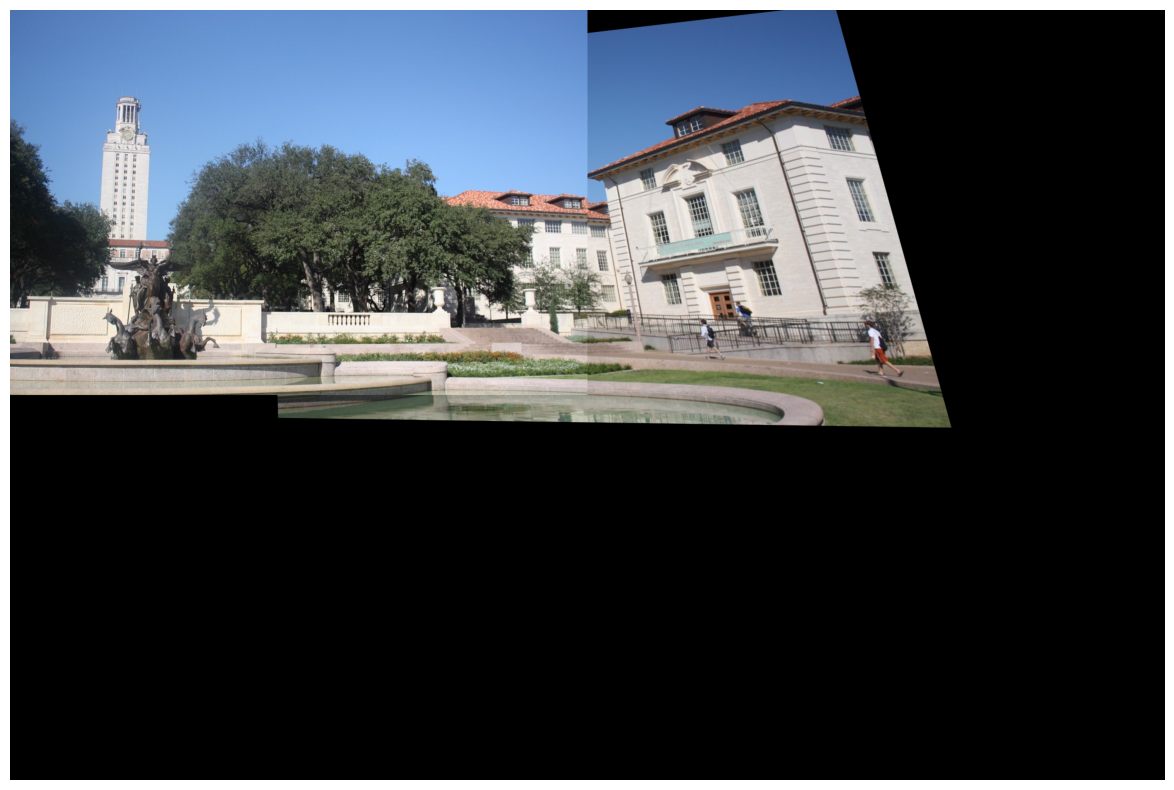

In [26]:
# Apply panorama correction
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

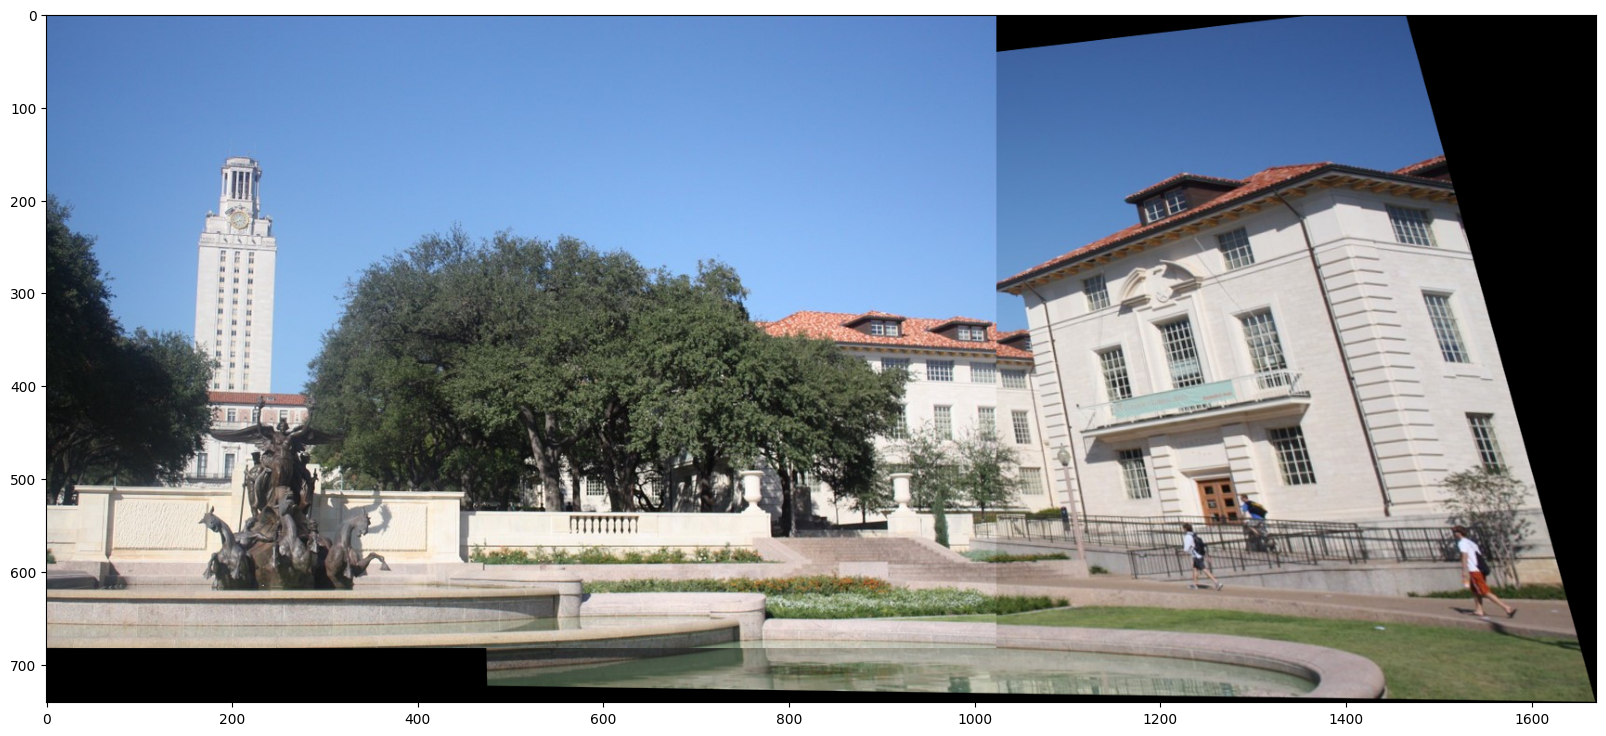

In [27]:
# transform the panorama image to grayscale and threshold it 
gray = img_as_ubyte(rgb2gray(result))
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)


### <font color='blue'><b> EXTENSION: </b></font>
  
Would you be able to generalize and stitch more than two images? HINT: choose an image ar target and tranform the other to that reference system